<a href="https://colab.research.google.com/github/lmendezayl/uba-ldd-tp1/blob/main/TP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Práctico 1 - Laboratorio de Datos - 1C 2025

**Integrantes del grupo:**
- Lautaro Evaristo Mendez
- Franco Zalazar
- Luca Emilio Petrarca

In [138]:
!pip install formulaic

In [139]:
# Si requieren mas librerias, pueden importarlas aca
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import seaborn.objects as so
import json
import plotly.express as px
from formulaic import Formula
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

# Si no existe root_mean_squared_error, quitarlo o actualizar scikit-learn con el comando
#!pip install scikit-learn --upgrade

Trabajaremos con el dataset `indicadores-proceso-trayectoria-sobreedad-2012_2022.csv1` que
contiene mediciones de variables educativas de la escuela primaria y secundaria en la Provincia de Buenos Aires (PBA) desde 2012 a 2022. En este [link](https://abc.gob.ar/secretarias/sites/default/files/2021-08/MANUAL%20METODOLÓGICO%20DE%20INDICADORES%20EDUCATIVOS-%202021.pdf) pueden consultar la descripción de cada variable.

In [140]:
url = 'https://raw.githubusercontent.com/lmendezayl/uba-ldd-tp1/refs/heads/main/indicadores-proceso-trayectoria-sobreedad-2012_2022.csv'
try:
  df_educacion = pd.read_csv('./indicadores-proceso-trayectoria-sobreedad-2012_2022.csv')
except:
  df_educacion = pd.read_csv(url)
df_educacion.head()

,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,alumnos_no_promovidos_primaria,alumnos_no_promovidos_secundaria,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria
0,2012,6007,Adolfo Alsina,100.26,84.14,1.25,9.06,0.07,1.79,-1.57,...,1.45,18.54,0.00,2.71,5.40,2.90,12.61,26.77,4.01,12.28
1,2013,6007,Adolfo Alsina,97.35,86.84,1.68,5.31,0.13,0.12,0.84,...,0.70,9.48,0.30,2.77,5.02,5.72,10.27,26.27,3.42,11.51
2,2014,6007,Adolfo Alsina,97.36,80.79,2.23,2.52,0.07,0.43,0.34,...,0.69,9.13,0.13,2.11,4.84,4.31,8.46,25.06,2.51,9.17
3,2015,6007,Adolfo Alsina,96.00,91.55,2.41,5.24,0.21,0.85,1.38,...,1.47,8.62,0.33,2.49,4.96,4.64,7.16,30.85,1.86,10.51
4,2016,6007,Adolfo Alsina,97.67,95.56,2.61,7.27,0.07,1.29,-0.35,...,1.58,6.95,0.14,2.79,4.72,3.57,6.81,26.13,1.69,8.24


### Procesamiento de Datos

En esta primera sección, vamos implementar algunas acciones básicas de procesamiento de nuestros datos

#### Ejercicio 1
Describir el tipo de variable de cada columna

Descripcion de las columnas y sus tipo de datos:

- `anio`: año en el que se realizó la medición. Es de tipo `int`.

- `municipio_id`: número de identificación de cada municipio. Es de tipo `int`.
- `municipio_nombre`: nombre del municipio. Es de tipo `string`. (dice`object` pero bueno).

Las siguientes columnas reemplazan la `X` por `primaria` o por `secundaria`:
- `promocion_efectiva_X`: porcentaje de alumnos que aprobaron las materias y pasaron de grado.  Tipo `float`.
    - Se calcula  `promocion_efectiva_X = 100 - repitencia_X - reinscripcion_X - abandono_interanual_X`.
  
- `repitencia_X`: porcentaje de alumnos que repitieron grado. Tipo `float`.
- `reinscripcion_X`: porcentaje de alumnos que dejaron los estudios y se reincorporaron al sistema. Tipo `float`.
- `alumnos_promovidos_X`: porcentaje de alumnos que pasaron de grado. Tipo `float`.

El siguiente grupo de indicadores de medición permite medir la eficiencia de la propia escuela, elaborado a partir de nuevas preguntas incluidas en los cuadernillos del Relevamiento Anual y los Relevamientos provinciales de la PBA:

- `alumnos_promovidos_X`: porcentaje de alumnos que pasaron de grado. Tipo `float`.
    - Se calcula como `alumnos_promovidos_X = 100 - alumnos_no_promovidos_X`.
    - A diferencia del indicador tradicional de tasa de egreso (según su fórmula de cálculo, estima la probabilidad de egreso de un estudiante), este indicador mide qué porcentaje de estudiantes que asistieron hasta el último día de clases aprobaron todas las materias, ya sea en el mes de diciembre o en el período complementario de los meses de enero o febrero del año siguiente.

- `alumnos_no_promovidos_X`: porcentaje de alumnos que no pasaron de grado (similar a una tasa de repetidores anual). Tipo `float`.
- `salidos_sin_pase_X`: porcentaje de alumnos que abandonaron la escuela sin un pase de traslado a otra institución.
- `salidos_con_pase_X`: porcentaje de alumnos que abandonaron la escuela con un pase para continuar sus estudios en otra institución.
- `sobreedad_X`: porcentaje de alumnos atrasados en su trayectoria escolar. Tipo `float`.
- `sobreedad_avanzada_X`: incluye sólo a los estudiantes que tienen dos o más años de atraso en su trayectoria escolar. Tipo `float`.

    - Se considera un recorte de `sobreedad_X`, ya que permite estimar una sobreedad neta porque algunos estudiantes tienen un año de sobreedad sólo por una diferencia de días o meses de nacimiento respecto de la edad mínima de ingreso a la escuela según la normativa.





In [141]:
df_educacion.dtypes

,0
anio,int64
municipio_id,int64
municipio_nombre,object
promocion_efectiva_primaria,float64
promocion_efectiva_secundaria,float64
repitencia_primaria,float64
repitencia_secundaria,float64
reinscripcion_primaria,float64
reinscripcion_secundaria,float64
abandono_interanual_primaria,float64


#### Ejercicio 2
¿La base de datos contiene datos faltantes? ¿Cuántos?

In [142]:
df_educacion.isna().sum()

,0
anio,0
municipio_id,0
municipio_nombre,0
promocion_efectiva_primaria,0
promocion_efectiva_secundaria,0
repitencia_primaria,0
repitencia_secundaria,0
reinscripcion_primaria,0
reinscripcion_secundaria,0
abandono_interanual_primaria,0


La base de datos no contiene ningun dato faltante!

#### Ejercicio 3
Además de la división por municipio, nos interesa saber a que zona de la provincia pertenece cada municipio (Zona Norte, Zona Oeste , Zona Sur e Interior). Para esto:
1. Implementar una función `determinar_zona` que, dado el nombre de un municipio, devuelva a que zona pertencece: ’Norte’, ’Oeste’, ’Sur’ o ’Interior’.
2. Agregar la columna zona a `df_educacion` que contenga la zona a la que pertenece el
municipio.
*Sugerencia*: tener en cuenta el método `apply`

In [143]:
def determinar_zona(municipio_nombre: str) -> str:
    zona_norte = ['San Isidro', 'Vicente Lopez', 'General San Martin', 'San Fernando', 'Tigre']
    zona_oeste = ['Moron', 'Tres de Febrero', 'La Matanza', 'Merlo', 'Moreno']
    zona_sur = ['Almirante Brown', 'Avellaneda', 'Quilmes', 'Lanus', 'Florencio Varela', 'Berazategui', 'Lomas de Zamora', 'Esteban Echeverria']
    zonas = {
        "Norte" : zona_norte,
        "Sur" : zona_sur,
        "Oeste" : zona_oeste}

    for zona in zonas.keys():
        if municipio_nombre in zonas[zona]:
            return zona
    return "Interior"

zonas_test = ["San Isidro", "Vicente Lopez", "Merlo", "Avellaneda", "Guernica"]
for zona in zonas_test:
    print(determinar_zona(zona))

Norte
Norte
Oeste
Sur
Interior


In [144]:
df_educacion["zona"] = df_educacion["municipio_nombre"].apply(determinar_zona)
df_educacion.head()

,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,alumnos_no_promovidos_secundaria,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria,zona
0,2012,6007,Adolfo Alsina,100.26,84.14,1.25,9.06,0.07,1.79,-1.57,...,18.54,0.00,2.71,5.40,2.90,12.61,26.77,4.01,12.28,Interior
1,2013,6007,Adolfo Alsina,97.35,86.84,1.68,5.31,0.13,0.12,0.84,...,9.48,0.30,2.77,5.02,5.72,10.27,26.27,3.42,11.51,Interior
2,2014,6007,Adolfo Alsina,97.36,80.79,2.23,2.52,0.07,0.43,0.34,...,9.13,0.13,2.11,4.84,4.31,8.46,25.06,2.51,9.17,Interior
3,2015,6007,Adolfo Alsina,96.00,91.55,2.41,5.24,0.21,0.85,1.38,...,8.62,0.33,2.49,4.96,4.64,7.16,30.85,1.86,10.51,Interior
4,2016,6007,Adolfo Alsina,97.67,95.56,2.61,7.27,0.07,1.29,-0.35,...,6.95,0.14,2.79,4.72,3.57,6.81,26.13,1.69,8.24,Interior


#### Ejercicio 4

Quisiéramos analizar si en general la tasa de repitencia es más alta en primaria que en secundaria. Para esto:
1. Agregar una columna `mayor_repitencia_primaria` a `df_educacion` que indique si ocurre
esta situación.
2. Mostrar en una Serie de `pandas` cuantas veces entre los años 2017 y 2022 (inclusive) la repitencia es más alta en primaria que en secundaria para cada municipio.
3. Mostrar en un DataFrame la media de repitencia en primaria y la media de repitencia en secundaria agrupados por año y por zona.

In [145]:
# 1
df_educacion['mayor_repitencia_primaria'] = df_educacion['repitencia_primaria'] > df_educacion['repitencia_secundaria']
df_educacion.head()

,anio,municipio_id,municipio_nombre,promocion_efectiva_primaria,promocion_efectiva_secundaria,repitencia_primaria,repitencia_secundaria,reinscripcion_primaria,reinscripcion_secundaria,abandono_interanual_primaria,...,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria,zona,mayor_repitencia_primaria
0,2012,6007,Adolfo Alsina,100.26,84.14,1.25,9.06,0.07,1.79,-1.57,...,0.00,2.71,5.40,2.90,12.61,26.77,4.01,12.28,Interior,False
1,2013,6007,Adolfo Alsina,97.35,86.84,1.68,5.31,0.13,0.12,0.84,...,0.30,2.77,5.02,5.72,10.27,26.27,3.42,11.51,Interior,False
2,2014,6007,Adolfo Alsina,97.36,80.79,2.23,2.52,0.07,0.43,0.34,...,0.13,2.11,4.84,4.31,8.46,25.06,2.51,9.17,Interior,False
3,2015,6007,Adolfo Alsina,96.00,91.55,2.41,5.24,0.21,0.85,1.38,...,0.33,2.49,4.96,4.64,7.16,30.85,1.86,10.51,Interior,False
4,2016,6007,Adolfo Alsina,97.67,95.56,2.61,7.27,0.07,1.29,-0.35,...,0.14,2.79,4.72,3.57,6.81,26.13,1.69,8.24,Interior,False


In [146]:
# 2
municipios = df_educacion['municipio_nombre'].unique() # array de todos los municipios
df_educacion_2017_2022 = df_educacion[df_educacion['anio'] >= 2017] # no hace falta poner que es menor que 2022 ya que es el maximo del conjunto de años.
cant_repitencia_2017_2022 = pd.Series()

for municipio in municipios:
    # dataframe temporal, siempre que se llame df_cache
    df_cache = df_educacion_2017_2022[df_educacion_2017_2022['municipio_nombre'] == municipio]
    cant_repitencia_2017_2022[municipio] = np.sum(df_cache['mayor_repitencia_primaria'])

cant_repitencia_2017_2022

,0
Adolfo Alsina,1
Alberti,1
Almirante Brown,1
Arrecifes,1
Avellaneda,1
...,...
25 de Mayo,1
Vicente Lopez,1
Villa Gesell,2
Villarino,1


In [147]:
# 2. Mostrar en una Serie de `pandas` cuantas veces entre los años 2017 y 2022 (inclusive) la repitencia es más alta en primaria que en secundaria para cada municipio.
cant_repitencias_2017_2022 = (
df_educacion[(df_educacion['anio'] >= 2017) & (df_educacion['mayor_repitencia_primaria'] == True)]
.groupby('municipio_nombre')['mayor_repitencia_primaria']
.count()
.reindex(df_educacion['municipio_nombre'].unique(), fill_value=0)
)

np.any(cant_repitencias_2017_2022 == cant_repitencia_2017_2022)


np.True_

In [148]:
# 3

df_media_repitencia = (
    df_educacion
    .groupby(['anio', 'zona'])
    .agg({
        'repitencia_primaria': 'mean',
        'repitencia_secundaria': 'mean'
        })
    .reset_index()
    .rename(columns={
        'repitencia_primaria': 'media_repitencia_primaria',
        'repitencia_secundaria': 'media_repitencia_secundaria'
        })
)
df_media_repitencia.head()

,anio,zona,media_repitencia_primaria,media_repitencia_secundaria
0,2012,Interior,2.457350,10.699316
1,2012,Norte,1.634000,8.978000
2,2012,Oeste,2.346000,9.932000
3,2012,Sur,2.470000,10.208750
4,2013,Interior,1.771368,10.499402


### Regresión
En esta sección, sugerimos que, una vez realizada una Regresión, utilicen los valores de $β_0$ y $β_1$ para predecir, en vez del método `predict` de `scikit-learn`.

#### Ejercicio 1
Reproducir el siguiente gráfico sobre la evolución de la sobreedad en secundaria promedio en la Provincia de Buenos Aires a lo largo de los años:

In [149]:

df_media_sobreedad_secundaria = df_educacion[['anio', 'sobreedad_secundaria']].copy()
df_media_sobreedad_secundaria = (
    df_media_sobreedad_secundaria
    .groupby(["anio"])
    .mean()
    .reset_index()
    .rename(columns={'sobreedad_secundaria' : 'sobreedad'})
)
df_media_sobreedad_secundaria

,anio,sobreedad
0,2012,35.344074
1,2013,32.554889
2,2014,31.719704
3,2015,30.535333
4,2016,29.719556
5,2017,28.883259
6,2018,27.584370
7,2019,26.282370
8,2020,24.578519
9,2021,22.097556


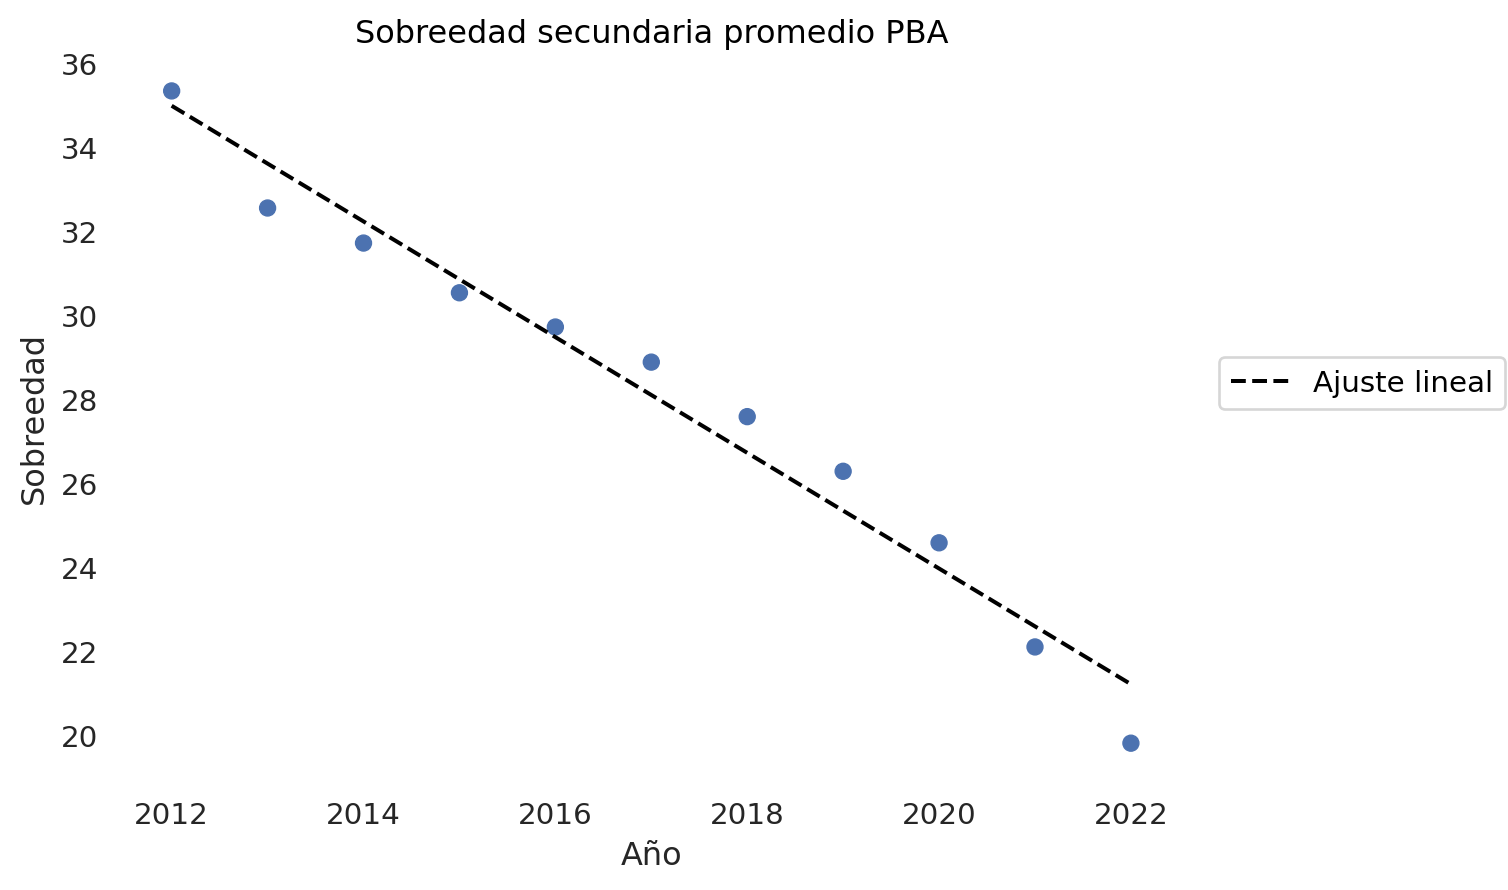

In [150]:
(
    so.Plot(data=df_media_sobreedad_secundaria,
            x=df_media_sobreedad_secundaria["anio"],
            y=df_media_sobreedad_secundaria["sobreedad"])
    .add(so.Line(linestyle='dashed', color="black"), so.PolyFit(1), label="Ajuste lineal")
    .add(so.Dot())
    .label(
        title="Sobreedad secundaria promedio PBA",
        x="Año",
        y="Sobreedad",
    )
    .theme({"axes.facecolor": "w"}) # lo tuve que buscar: https://seaborn.pydata.org/generated/seaborn.objects.Plot.theme.html
)

# agregar conclusion?

#### Ejercicio 2
Realizando una Regresión Lineal, predecir para el año 2025 la sobreedad en secundaria promedio en la Provincia de Buenos Aires

In [151]:
y, X = Formula('sobreedad ~ anio').get_model_matrix(df_media_sobreedad_secundaria)
modelo = linear_model.LinearRegression(fit_intercept=False)
modelo.fit(X, y)
beta_0, beta_1 = modelo.coef_[0]
prediccion_2025 = beta_0 + beta_1*2025
prediccion_2025

np.float64(17.075587878787246)

#### Ejercicio 3
Para cada municipio del Área Metropolitana, mediante Regresión Lineal, predecir la sobreedad en secundaria para el 2025. Elaborar un DataFrame indexado por el nombre del municipio, con dos columnas: `sobreedad_2025` con el resultado de la predicción para 2025
y `menor_que_promedio` que indique con un booleano si la predicción es menor al valor calculado en el ítem anterior.

**Sugerencia**: puede basarse en la siguiente estructura


In [152]:
area_metropolitana = ['Almirante Brown', 'Avellaneda', 'Berazategui', 'Berisso', 'Brandsen', 'Campana', 'Cañuelas',
                      'Ensenada', 'Escobar', 'Esteban Echeverria', 'Exaltacion de la Cruz', 'Ezeiza',
                      'Florencio Varela', 'General Las Heras', 'General Rodriguez', 'General San Martin', 'Hurlingham',
                      'Ituzaingo', 'Jose C. Paz', 'La Matanza', 'La Plata', 'Lanus', 'Lujan', 'Lomas de Zamora',
                      'Malvinas Argentinas', 'Marcos Paz', 'Merlo', 'Moreno', 'Moron', 'Pilar', 'Presidente Peron',
                      'Quilmes', 'San Fernando', 'San Isidro', 'San Miguel', 'San Vicente', 'Tigre', 'Tres de Febrero',
                      'Vicente Lopez', 'Zarate']

In [153]:

prediccion_data = []
menor_que_promedio_data = []
for municipio in area_metropolitana:
    df_partidos = df_educacion[df_educacion['municipio_nombre'] == municipio]
    y, X = Formula("sobreedad_secundaria ~ anio").get_model_matrix(df_partidos)
    modelo_p = linear_model.LinearRegression(fhttps://raw.githubusercontent.com/lmendezayl/uba-ldd-tp1/refs/heads/main/indec_2022_condiciones_habitacionales.csv
    beta_0, beta_1 = modelo_p.coef_[0]
    prediccion = beta_0 + beta_1 * 2025
    prediccion_data.append(prediccion)
    menor_que_promedio_data.append(prediccion < prediccion_2025)

predicciones_df = pd.DataFrame(
    data = {'sobreedad_2025': prediccion_data, 'menor_que_promedio': menor_que_promedio_data},
    index = area_metropolitana
)



predicciones_df.head()


,sobreedad_2025,menor_que_promedio
Almirante Brown,15.068727,True
Avellaneda,24.418727,False
Berazategui,19.230182,False
Berisso,28.410727,False
Brandsen,20.656727,False


### Visualización con datos geográficos
El objetivo de esta parte del TP es visualizar datos sobre un mapa de Buenos Aires. Para esto, utilizaremos las librerías `geopandas`, que nos permite trabajar con un .geojson como si fuera un DataFrame de `pandas`, y `plotly` para generar mapas interactivos

#### Ejercicio 1
Cargar los datos de `partidos.geojson` utilizando `geopandas`:



In [154]:
# Cargamos el archivo de datos
try:
    geo_df = gpd.read_file('partidos.geojson')
except:
    url = 'https://raw.githubusercontent.com/lmendezayl/uba-ldd-tp1/blob/main/partidos.geojson'
    geo_df = gpd.read_file(url)

HTTPError: HTTP Error 404: Not Found


Si imprimimos `geo_df` observamos que cada fila corresponde a un municipio con distintas
características y, además, hay una columna `geometry` que tiene las coordenadas de los límites de los partidos. Pueden visualizar estos datos con `geo_df.plot()`.

In [ ]:
# Visualizamos los partidos
geo_df.plot()

#### Ejercicio 2
Identificar qué columna se corresponde al número de identificación de cada municipio. Mostrar
todos los municipios con números de identificación repetidos.
**Sugerencia**: utilizar el argumento `keep` del método `duplicated`

In [ ]:
# cde tiene el numero de identificacion!
print(len(geo_df['cde'].unique()))
print(len(geo_df['cde']))

nombres = pd.concat([geo_df[geo_df['cde'].duplicated(keep='last')]['nam'], geo_df[geo_df['cde'].duplicated(keep='first')]['nam']])
print("\n", nombres)


geo_df.head()

#### Ejercicio 3
Aplicar las siguientes modificaciones a `geo_df`:
1. eliminar las filas que correspondan a islas de partidos (por ejemplo, Islas Ramallo).
2. convertir la columna `cde` a numérica (recordar el método `astype`)
3. corregir los valores en la columna cde para los partidos de Chascomús y Lezama, para
que coincidan con sus valores en la columna `municipio_id` de `df_educacion`. **Sugerencia**: puede basarse en el siguiente código para corregir los valores:

`geo_df.loc[geo_df[???] == ???, <columna a modificar>] = ???`

Finalmente, exportar `geo_df` como un GeoJSON llamado `partidos_limpio.geojson`:

In [ ]:
df_educacion[df_educacion['municipio_nombre'] == 'Lezama']['municipio_id'].unique()[0]

In [ ]:

def eliminar_islas(df):
    return df[~df['nam'].str.startswith("Islas")]

def convertir_cd_a_int(df):
    df['cde'] = df['cde'].astype(int)
    return df

def mapear_ids_chascomus_lezama(df):
    nuevo_id_chascomus = df_educacion[df_educacion['municipio_nombre'] == 'Chascomus']['municipio_id'].unique()[0]
    nuevo_id_lezama = df_educacion[df_educacion['municipio_nombre'] == 'Lezama']['municipio_id'].unique()[0]
    viejo_id_chascomus = df[df['nam'] == 'Chascomús']['cde'].unique()[0]
    viejo_id_lezama = df[df['nam'] == 'Lezama']['cde'].unique()[0]
    df['cde'].replace({viejo_id_chascomus: nuevo_id_chascomus, viejo_id_lezama: nuevo_id_lezama})
    return df

geo_df


geo_df = (
 geo_df.copy()
 .pipe(eliminar_islas)
 .pipe(mapear_ids_chascomus_lezama)
 .pipe(convertir_cd_a_int)
     )


In [ ]:
# Grabamos los datos limpios en un nuevo archivo GeoJSON
geo_df.to_file('partidos_limpio.geojson', driver='GeoJSON')

In [ ]:
# Limpieza de datos. Seguir las indicaciones en la consigna del TP para este paso.


#### Ejercicio 4
A partir del DataFrame `df_educacion`, crear un DataFrame `repit` que tenga tres colum-
nas: `cde` con el código del municipio, `municipio_nombre` con el nombre del municipio y
`repitencia_secundaria` con el promedio de repitencia en secundaria del municipio.

**Sugerencia**: Partir de `df_educacion.groupby(['municipio_id', 'municipio_nombre'])`.
Si obtienen una serie con multi-indices, pueden convertirlo a DataFrame con columnas para los índices utilizando `.reset_index()`. O si ingresan el nombre de la columna `repitencia_secundaria` entre doble corchetes, obtienen también un DataFrame con las tres columnas

In [ ]:
# Creamos un DataFrame repit con los datos de repitencia siguiendo la consigna del TP
repit  = df_educacion.groupby(['municipio_id', 'municipio_nombre'])['repitencia_secundaria'].mean().reset_index().rename(columns={"municipio_id": "cde"})
repit



#### Ejercicio 5
Con el siguiente código podemos elaborar un mapa interactivo:

In [ ]:
with open('partidos_limpio.geojson', 'r') as f:
    partidos = json.load(f)

fig = px.choropleth_map(
    repit,
    geojson=partidos,
    featureidkey = 'properties.cde',
    locations='cde',
    color='repitencia_secundaria',
    zoom = 4,
    center = {"lat": -34.61315, "lon": -58.37723},
    color_continuous_scale="Bluered",
    opacity=0.7,
    hover_name="municipio_nombre"
)

fig.show()

Agregar argumentos a `choropleth_map` para que:
1. la escala de color sea 'Bluered' (pueden ver otras escalas de color en este link)
2. la opacidad del color sea de 0.7
3. que al pasar el cursor sobre un partido, se muestre también su nombre

In [ ]:
# Generamos un gráfico interactivo para el nivel de repitencia

# Si no existe chorpleth_map o alguna opcion del codigo en la siguiente celda, actualizar plotly con el siguiente comando y reiniciar el kernel.
#!pip install plotly --upgrade

# Si tienen algún error de Java después de instalar los paquetes actualizados y reiniciar el kernel, prueben refrescar el navegador con CTRL+F5.

### Análisis exploratorio

La idea de este ítem es que realicen un análisis exploratorio de los datos, aplicando las herramientas de visualización (seaborn.objects, seaborn y/o matplotlib), de resumen de datos (media, mediana, desvío estándar, operaciones sobre el DataFrame, etc.) y/o de Regresión.
El objetivo es entender, comparar y/o estudiar aspectos en los indicadores educativos de los partidos de la Provincia de Buenos Aires. Algunas preguntas disparadoras pueden ser:
- ¿Existe alguna relación entre la repitencia y los fondos enviados al partido para la educación?
- ¿Podemos explicar por qué hay algunos partidos con repitencia muy superior al promedio?
- ¿Qué relación hay entre la cantidad de habitantes y la cantidad de establecimientos educativos?
-
No es necesario que respondan a cada una de esas preguntas (ni se limiten a eso), lo mejor es que exploren por donde se les ocurra. Alentamos que se planteen hipótesis y usen los datos para corroborarlas o rechazarlas. Pueden aplicar cualquiera de las herramientas que hemos visto hasta ahora. Asimismo, pueden centrarse en un conjunto de partidos, en un conjunto de indicadores educativos, etc.

A continuación dejamos otros datasets que pueden serles de ayuda (su uso es opcional):
- [Establecimientos educativos](https://catalogo.datos.gba.gob.ar/dataset/establecimientos-educativos)
- [Población](https://catalogo.datos.gba.gob.ar/dataset/poblacion)
- [Transferencias a Consejos Escolares](https://catalogo.datos.gba.gob.ar/dataset/tranferencias-consejos-escolares)
- [Transferencias a municipios](https://catalogo.datos.gba.gob.ar/dataset/transferencias-municipios)

También pueden explorar datasets del Gobierno Nacional o de la Ciudad de Buenos Aires (pero
que el análisis esté centrado en PBA).


**Importante**: en el Notebook, las visualizaciones y resúmenes de datos que realicen deben
estar acompañados por las conclusiones que obtengan a partir de ellos.

Los municipios con peores condiciones habitacionales en 2022 tienen mayores tasas de abandono/repitecia en 2022

Justificación: La precariedad habitacional suele correlacionarse con vulnerabilidad socioeconómica, que impacta en la asistencia y desempeño escolar

La sobreedad avanzada está asociada a municipios con mayor densidad poblacional y hacinamiento

Justificación: El hacinamiento dificulta el estudio en el hogar, generando rezago escolar acumulado.


Los municipios con mejor infraestructura habitacional tienen menor variabilidad en las tasas de abandono (2012-2022)

La estabilidad en las condiciones de vida podría amortiguar crisis económicas o sociales que afectan la deserción escolar.

Queremos ver si podemos entrenar un modelo que a partir de los datos de condiciones habitacionales de 2022, sea capaz de predecir algunas de las tasas que se encuentran en `df_educacion` para el año 2022.

Debido a que solo tenemos datos sobre las condiciones habitacionales del ultimo censo, (datos de 2022), tenemos una limitacion muy estricta. Debido a esto, la metodologia que usaremos será tomar el 85% de los partidos en la Pcia. de Bs. As. y entrenar al modelo, para luego verificar con el 15% de los partidos restantes si el modelo predice correctamente las tasas de los partidos de
verificacion.

Tambien, intentaremos dar una estimacion preliminar sobre los datos de educacion de 2023 usando el modelo y asumiendo que las condiciones habitacionales se mantienen constantes con los años, pero no podremos verificarlos pues no hay datos publicados de 2023 aun. La eleccion de 2023 no es arbitraria, esta claro que a mas alejado el año se encuentra de 2022, mayor es el error de la prediccion realizada por el modelo. Por otro lado, no podemos intentar predecir los datos de 2021 y de 2020, ya que poseen un sesgo muy marcado por la pandemia de COVID-19 y deben ser considerados casos aislados. Años pre-pandemia no son comparables debido a diferencias estructurales en el sistema educativo, como la virtualidad como norma, colegios menos restrictivos, entre otros cambios. Por esto mismo, debe ser considerado como una prediccion basada en patrones observados mas que en relaciones causales.  

Para ello, como mencionamos anteriormente, haremos uso de los datos publicados en ["*Censo Nacional de Población, Hogares y Viviendas 2022, Resultados provisionales, Indicadores de las condiciones habitacionales de las viviendas particulares ocupadas*"](https://www.indec.gob.ar/ftp/cuadros/poblacion/cnphv2022_condiciones_habitacionales_05_23A5A5DCDF38.pdf). En particular, nos interesa el apartado de estadisticas de la Provincia de Buenos Aires, en las paginas 14 a 17 (inclusive).

Lo siguiente es una breve descripcion de las columnas presentes en la bas de datos `df_censo_2022_cond_hab`:

**Indicadores seleccionados**
- **Pisos con revestimiento**: el material predominante de los pisos es cerámica,
mosaico, baldosa, alfombra, madera, flotante, vinílico, microcemento, cemento alisado
o mármol.
- **Agua por cañería dentro de la vivienda**: tiene agua por cañería dentro de la
vivienda.
- **Agua para beber y cocinar por red pública**: el agua que usa para beber y cocinar
proviene de red pública (agua corriente).
- **Baño o letrina dentro de la vivienda**: tiene baño o letrina dentro de la vivienda.
- **Dos o más baños**: tiene dos o más baños.
- **Baño con inodoro con arrastre de agua**: tiene baño que posee inodoro con botón,
mochila o cadena (arrastre de agua).
- **Desagüe del inodoro a red pública**: tiene desagüe del inodoro a red pública (cloaca).
- **Gas de red o electricidad para cocinar**: utiliza para cocinar principalmente gas de
red o electricidad.
- **Vivienda propia**: la vivienda es propia.
- **Internet**: tiene internet.
- **Celular con internet**: tiene celular con internet.
- **Computadora o tablet u otros**: tiene computadora, tablet, etcétera.


In [155]:
# Importamos el dataset
# manejo de error por si estamos en local o no
try:
    df_censo_2022_cond_hab = pd.read_csv("indec_2022_condiciones_habitacionales.csv")
except:
    url = 'https://raw.githubusercontent.com/lmendezayl/uba-ldd-tp1/refs/heads/main/indec_2022_condiciones_habitacionales.csv'
    df_censo_2022_cond_hab = pd.read_csv(url)

# Chequeamos que no hayan datos NaN, como solo da [False] significa que no hay datos NaN
print(df_censo_2022_cond_hab.isna().any().unique())

# mostramos el dataset
display(df_censo_2022_cond_hab.head())

[False]


,Partido,Pisos con revestimiento,Agua por canieria dentro de la vivienda,Agua para beber y cocinar por red publica,Banio o letrina dentro de la vivienda,Dos o mas banios,Banio con inodoro con arrastre de agua,Desague del inodoro del banio a red publica,Gas de red o electricidad para cocinar,Vivienda propia,Internet,Celular con internet,Computadora o tablet u otros
0,Almirante Brown,83.7,90.5,54.8,96.3,20.3,85.4,41.4,65.1,73.3,83.0,91.6,55.9
1,Avellaneda,92.9,96.4,96.6,96.4,23.7,94.3,81.1,78.2,64.0,85.6,92.4,65.3
2,Berazategui,85.8,95.0,89.8,96.7,23.1,90.0,77.1,67.4,71.1,86.3,92.7,58.3
3,Esteban Echeverría,81.1,89.4,61.0,95.9,23.3,84.8,50.4,61.2,70.4,82.4,92.1,54.5
4,Ezeiza,78.0,87.7,49.4,96.0,20.0,82.8,35.7,55.0,72.9,76.8,91.7,51.4


In [156]:
# Limpieza de datos
import re

cambiar_tildes = {"á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u", "ü": "u"}
pattern = re.compile("|".join(cambiar_tildes.keys())) # lo busque, no tengo idea como funciona una regex perdon soy de datos

# Funcion para sacar tildes de nombres
def destildar(texto):
    return pattern.sub(lambda x: cambiar_tildes[x.group()], texto)

# Limpiamos tildes de nombres de partidos por letras sin tilde
df_censo_2022_cond_hab['Partido'] = df_censo_2022_cond_hab['Partido'].apply(destildar)

# Formateamos la tabla
df_censo_2022_cond_hab = (
    df_censo_2022_cond_hab
    .rename(columns={"Partido" : 'municipio_nombre'}) # Igualamos nombre de columna de df_educacion para poder realizar un merge
    .set_index('municipio_nombre')
    .sort_index()
    .reset_index()) # un poco de tira y afloja con municipio_nombre porque no sabia hacerlo sino

In [158]:
# Verificamos que tengamos los mismos valores en ambas tablas para poder hacer un join usando comparacion de tipo set para ignorar orden de datos.
set_censo = set(df_censo_2022_cond_hab['municipio_nombre'].unique().tolist())
set_educ = set(df_educacion['municipio_nombre'].unique().tolist())
print(set_censo == set_educ)
# ya chequee que las filas sean las mismas, sort_index me lo garantiza, aun asi ya lo mire, podemos confiar en pandas

True


In [159]:
# creamos una subtabla de df_educacion que solo tenga el nombre del municipio y las tasas
df_educacion_2022 = (
    df_educacion[df_educacion['anio'] == 2022]
    .set_index('municipio_nombre')
    .sort_index()
    .reset_index()
    .drop(columns = ['anio', 'zona', 'mayor_repitencia_primaria'])
)

In [160]:
# creamos un mapa entre nombre e id de municipio, puede ser util para no tener que tener strings en el df...
mapa_nombre_id = dict(zip(df_educacion_2022['municipio_id'], df_educacion_2022['municipio_nombre']))
# Por ejemplo, si queremos ver cual es el municipio con id=6854:
mapa_nombre_id[6854]

'25 de Mayo'

In [161]:
# Preprocesamiento de los datos

# ahora que ambos dataframes tienen el mismo orden, agregamos los id a df_censo_2022_cond_hab
df_censo_2022_cond_hab["municipio_id"] = df_educacion_2022['municipio_id']

# y ahora que tenemos el id, no necesitamos trabajar mas con los nombres de los municipios como string
# total si necesitasemos saber algun nombre, tenemos el diccionario mapa_nombre_id para buscarlo
df_educacion_2022 = df_educacion_2022.drop(columns='municipio_nombre')
df_censo_2022_cond_hab = df_censo_2022_cond_hab.drop(columns='municipio_nombre')

# hacemos un merge para tener el dataframe deseado, usando municipio_id como key
df = pd.merge(df_censo_2022_cond_hab, df_educacion_2022, on='municipio_id', how="inner")
df = df[['municipio_id', 'Pisos con revestimiento',
       'Agua por canieria dentro de la vivienda',
       'Agua para beber y cocinar por red publica',
       'Banio o letrina dentro de la vivienda', 'Dos o mas banios',
       'Banio con inodoro con arrastre de agua',
       'Desague del inodoro del banio a red publica',
       'Gas de red o electricidad para cocinar', 'Vivienda propia', 'Internet',
       'Celular con internet', 'Computadora o tablet u otros',
       'promocion_efectiva_primaria', 'promocion_efectiva_secundaria',
       'repitencia_primaria', 'repitencia_secundaria',
       'reinscripcion_primaria', 'reinscripcion_secundaria',
       'abandono_interanual_primaria', 'abandono_interanual_secundaria',
       'alumnos_promovidos_primaria', 'alumnos_promovidos_secundaria',
       'alumnos_no_promovidos_primaria', 'alumnos_no_promovidos_secundaria',
       'salidos_sin_pase_primaria', 'salidos_sin_pase_secundaria',
       'salidos_con_pase_primaria', 'salidos_con_pase_secundaria',
       'sobreedad_primaria', 'sobreedad_secundaria',
       'sobreedad_avanzada_primaria', 'sobreedad_avanzada_secundaria']]

In [167]:
# para elegir las tasas que nos conviene intentar predecir, usamos la matriz de correlacion sin municipio_id
df_corr = df.drop(columns=['municipio_id']).corr()
df_corr

,Pisos con revestimiento,Agua por canieria dentro de la vivienda,Agua para beber y cocinar por red publica,Banio o letrina dentro de la vivienda,Dos o mas banios,Banio con inodoro con arrastre de agua,Desague del inodoro del banio a red publica,Gas de red o electricidad para cocinar,Vivienda propia,Internet,...,alumnos_no_promovidos_primaria,alumnos_no_promovidos_secundaria,salidos_sin_pase_primaria,salidos_sin_pase_secundaria,salidos_con_pase_primaria,salidos_con_pase_secundaria,sobreedad_primaria,sobreedad_secundaria,sobreedad_avanzada_primaria,sobreedad_avanzada_secundaria
Pisos con revestimiento,1.000000,0.888985,0.476057,0.739428,0.360316,0.953099,0.509624,0.682127,-0.547767,0.252052,...,-0.183161,0.007696,-0.115820,0.194875,-0.111286,0.043763,-0.097165,-0.288303,-0.404797,-0.223608
Agua por canieria dentro de la vivienda,0.888985,1.000000,0.685531,0.719594,0.369197,0.924948,0.663831,0.672746,-0.523163,0.261793,...,-0.232554,0.056145,-0.121774,0.179760,-0.108256,0.063506,-0.118560,-0.228276,-0.392229,-0.159493
Agua para beber y cocinar por red publica,0.476057,0.685531,1.000000,0.225921,0.164607,0.565583,0.644438,0.551771,-0.285401,0.134427,...,-0.100192,0.072993,-0.038039,0.022022,-0.106916,0.062592,-0.026959,-0.071475,-0.215006,0.006968
Banio o letrina dentro de la vivienda,0.739428,0.719594,0.225921,1.000000,0.236336,0.723592,0.404032,0.440988,-0.321342,0.102774,...,-0.216062,-0.083558,-0.099842,0.137828,-0.155770,0.104796,-0.133013,-0.334308,-0.346847,-0.311739
Dos o mas banios,0.360316,0.369197,0.164607,0.236336,1.000000,0.283498,0.319566,0.476271,-0.381729,0.493866,...,-0.180352,-0.039163,-0.016145,-0.074825,-0.120941,-0.121271,-0.109383,-0.007993,-0.039260,-0.014272
Banio con inodoro con arrastre de agua,0.953099,0.924948,0.565583,0.723592,0.283498,1.000000,0.563261,0.611566,-0.540925,0.152617,...,-0.247422,0.022998,-0.119490,0.217200,-0.078650,0.098948,-0.147239,-0.295559,-0.479238,-0.230916
Desague del inodoro del banio a red publica,0.509624,0.663831,0.644438,0.404032,0.319566,0.563261,1.000000,0.540966,-0.312717,0.119352,...,-0.157601,0.074152,-0.035516,0.112139,-0.226960,0.006971,-0.061094,-0.047309,-0.156199,-0.014841
Gas de red o electricidad para cocinar,0.682127,0.672746,0.551771,0.440988,0.476271,0.611566,0.540966,1.000000,-0.341114,0.473540,...,-0.034838,-0.002080,0.026939,0.101394,-0.144385,-0.077155,0.095344,-0.115652,-0.109896,-0.062723
Vivienda propia,-0.547767,-0.523163,-0.285401,-0.321342,-0.381729,-0.540925,-0.312717,-0.341114,1.000000,-0.277375,...,-0.006381,-0.081637,0.031594,-0.036888,-0.153579,-0.072744,-0.100054,0.010244,0.101668,0.028105
Internet,0.252052,0.261793,0.134427,0.102774,0.493866,0.152617,0.119352,0.473540,-0.277375,1.000000,...,0.046402,-0.014637,-0.046704,0.006601,-0.221059,-0.075155,0.107342,0.055879,0.166933,0.057206
